In [ ]:
from importlib import reload
from datetime import datetime
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

import utils
reload(utils)

In [ ]:
ceased_labours = pd.read_csv('Rapporti_di_lavoro_cessati.csv')
ceased_labours.head()

# Transformations

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
one_hot_encoder = OneHotEncoder()
label_encoder = LabelEncoder()

In [ ]:
ceased_transformed = pd.DataFrame()

##### GENERE -> dummies

In [ ]:
df_col = ceased_labours['GENERE'].values.reshape(-1,1)
df_col

array([['M'],
       ['F'],
       ['F'],
       ...,
       ['M'],
       ['M'],
       ['M']], dtype=object)

In [ ]:
X = one_hot_encoder.fit_transform(df_col).toarray()

In [ ]:
ceased_transformed = pd.concat(
    [ceased_transformed, pd.DataFrame(X, columns=['GENERE_F', 'GENERE_M'])],
    axis=1
)
ceased_transformed.head()

,GENERE_F,GENERE_M
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,0.0,1.0
4,0.0,1.0


##### TITOLO STUDIO -> custom transformation
following this ordinal rules [ISTAT document](https://www.istat.it/it/files/2011/01/Classificazione-titoli-studio-28_ott_2005-nota_metodologica.pdf)

In [ ]:
ceased_labours.TITOLOSTUDIO.unique()

array(["DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA",
       'LICENZA MEDIA',
       "TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L'ACCESSO ALL'UNIVERSITÀ ()",
       'LICENZA ELEMENTARE', 'NESSUN TITOLO DI STUDIO',
       'LAUREA - Vecchio o nuovo ordinamento', 'DIPLOMA UNIVERSITARIO',
       'DIPLOMA DI SPECIALIZZAZIONE', 'TITOLO DI STUDIO POST-LAUREA',
       'TITOLO DI DOTTORE DI RICERCA',
       'MASTER UNIVERSITARIO DI PRIMO LIVELLO',
       'DIPLOMA TERZIARIO EXTRA-UNIVERSITARIO'], dtype=object)

In [ ]:
mapper = {
    'NESSUN TITOLO DI STUDIO': 0,
    'LICENZA ELEMENTARE': 1,
    'LICENZA MEDIA': 2,
    'TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L\'ACCESSO ALL\'UNIVERSITÀ ()': 3,
    'DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L\'ACCESSO ALL\'UNIVERSITA': 4,
    'DIPLOMA TERZIARIO EXTRA-UNIVERSITARIO': 5,
    'DIPLOMA UNIVERSITARIO': 6,
    'LAUREA - Vecchio o nuovo ordinamento': 7,
    'MASTER UNIVERSITARIO DI PRIMO LIVELLO': 8,
    'DIPLOMA DI SPECIALIZZAZIONE': 9,
    'TITOLO DI DOTTORE DI RICERCA': 10,
    'TITOLO DI STUDIO POST-LAUREA': 11
}
ceased_transformed['TITOLOSTUDIO'] = ceased_labours['TITOLOSTUDIO'].replace(mapper)
ceased_transformed.head()

,GENERE_F,GENERE_M,TITOLOSTUDIO
0,0.0,1.0,4.0
1,1.0,0.0,4.0
2,1.0,0.0,4.0
3,0.0,1.0,2.0
4,0.0,1.0,2.0


In [ ]:
ceased_transformed.TITOLOSTUDIO.unique()

array([ 4.,  2.,  3.,  1.,  0., nan,  7.,  6.,  9., 11., 10.,  8.,  5.])

##### TODO: inspect why missing values are introduced

In [ ]:
utils.missing_values_table(ceased_transformed)

Your selected dataframe has 3 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
TITOLOSTUDIO,12992,0.3


##### MODALITÀ LAVORO -> LabelEncoder

In [ ]:
ceased_labours.MODALITALAVORO.unique()

array(['TEMPO PIENO', 'NON DEFINITO', 'TEMPO PARZIALE ORIZZONTALE',
       'TEMPO PARZIALE VERTICALE', 'TEMPO PARZIALE MISTO'], dtype=object)

In [ ]:
ceased_transformed['MODALITALAVORO'] = label_encoder.fit_transform(ceased_labours.MODALITALAVORO)
ceased_transformed.head()

,GENERE_F,GENERE_M,TITOLOSTUDIO,MODALITALAVORO
0,0.0,1.0,4.0,4
1,1.0,0.0,4.0,4
2,1.0,0.0,4.0,4
3,0.0,1.0,2.0,4
4,0.0,1.0,2.0,4


In [ ]:
ceased_transformed.MODALITALAVORO.unique()

array([4, 0, 2, 3, 1])

# Time Analysis

In [ ]:
timed_labours = ceased_labours.copy()

##### Convert 'DATA' column into datetime field

Control the format

In [ ]:
r = re.compile(r'[0-9][0-9]\/[0-9][0-9]\/[0-9][0-9][0-9][0-9]')
regmatch = np.vectorize(lambda x: bool(r.match(x)))

matches = regmatch(timed_labours.DATA.values)
if np.count_nonzero(matches) == len(timed_labours.DATA):
    print("All the values in the data columns matches the pattern")
else:
    raise Exception("ERROR: not all the values in the data columns matches the pattern")

All the values in the data columns matches the pattern


Convert the data

In [ ]:
timed_labours.DATA= timed_labours.DATA.apply(
    lambda date_str: datetime.strptime(date_str, "%d/%m/%Y")
)

In [ ]:
timed_labours.DATA.head()

0   2019-04-02
1   2018-06-08
2   2016-02-02
3   2015-01-12
4   2017-08-09
Name: DATA, dtype: datetime64[ns]

In [ ]:
timed_labours.dtypes

DATA                         datetime64[ns]
GENERE                               object
ETA                                   int64
SETTOREECONOMICODETTAGLIO            object
TITOLOSTUDIO                         object
CONTRATTO                            object
MODALITALAVORO                       object
PROVINCIAIMPRESA                     object
NAZIONALITA                          object
dtype: object

Sort by date

In [ ]:
utils.sort_by(timed_labours, 'DATA')

Sorted


Create the month and year columns

In [ ]:
timed_labours['MONTH'] = timed_labours.DATA.apply(lambda _date: _date.month)

In [ ]:
timed_labours['YEAR'] = timed_labours.DATA.apply(lambda _date: _date.year)

Set the DATA columns as the index

In [ ]:
timed_labours.set_index('DATA', inplace=True)

Distribution of ceased labours in all years by month

In [ ]:
monthly_count = timed_labours.groupby(timed_labours.index.month).count().iloc[:, [0]]
monthly_count.rename(columns={'GENERE': 'COUNT'}, inplace=True)
monthly_count

,COUNT
DATA,
1,439207
2,477084
3,436162
4,408013
5,326566
6,225558
7,231168
8,218143
9,236740


<AxesSubplot:title={'center':'Ceased labours for every month of each year'}, xlabel='months', ylabel='counts'>

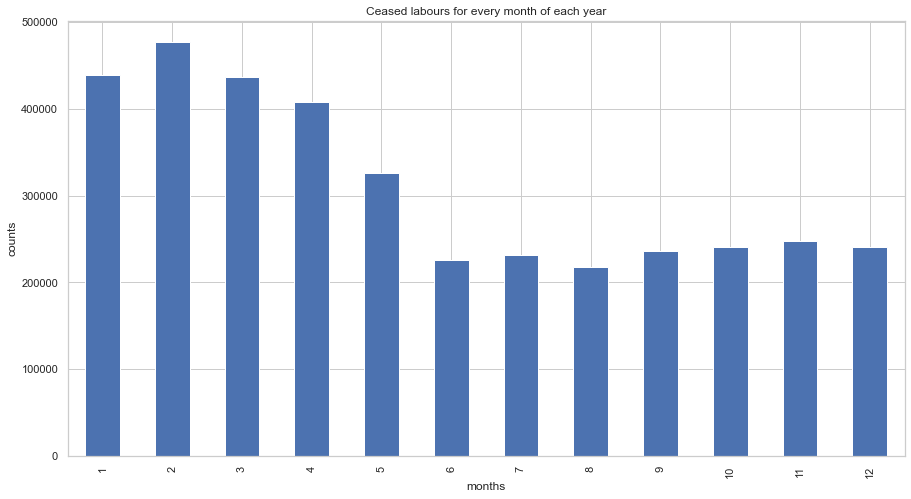

In [ ]:
monthly_count.plot(
    title='Ceased labours for every month of each year',
    xlabel='months',
    ylabel='counts',
    kind='bar',
    legend=False,
    figsize=(15, 8)
)

##### Analyze the time series

In [ ]:
timed_labours2 = timed_labours[['GENERE']]

In [ ]:
timed_labours2 = timed_labours2.resample('M').count()
timed_labours2.rename(columns={'GENERE': 'COUNT'}, inplace=True)

In [ ]:
# filter data that are too low
timed_labours2 = timed_labours2[timed_labours2.COUNT > 5000]

<AxesSubplot:xlabel='DATA'>

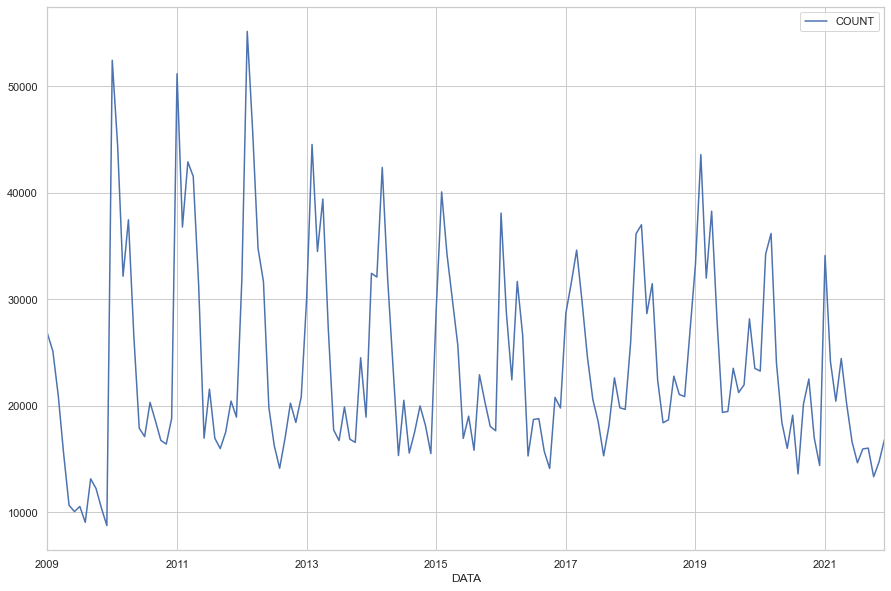

In [ ]:
timed_labours2.plot()

Autocorrelation

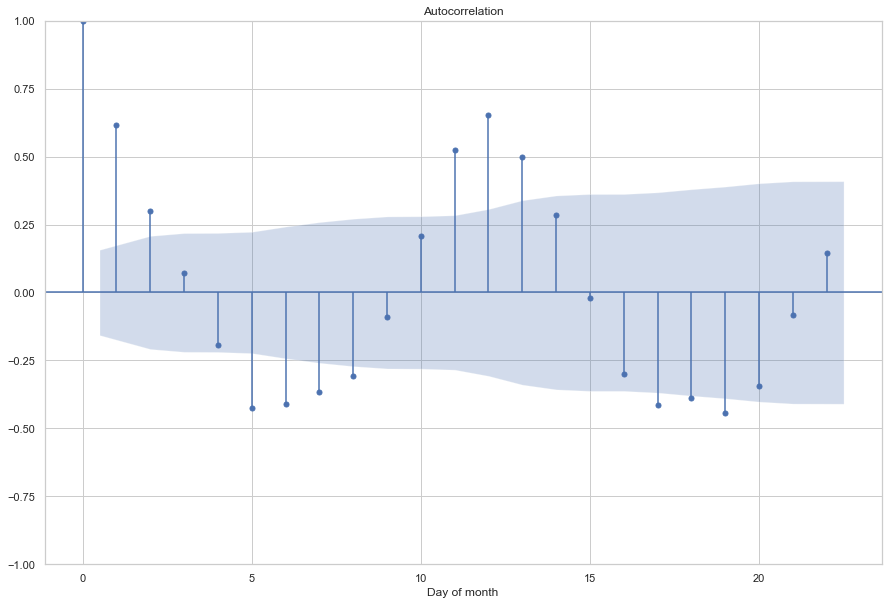

In [ ]:
plt.rc('figure', figsize=(15, 10))
plot_acf(timed_labours2)
plt.xlabel('Years')
plt.show()

There is a little correlation during the first day of the months